# Homework 4 -  Least-squares parameter estimation

**Due Friday October 18 at end-of-day**

The model structure used is the so-called ARX (Auto-Regressive with eXogenous input) model:
![ARX block diagram](arx-block.png "ARX model")
 where $u(k)$ is a known input signal, $y(k)$ is the output signal and $e(k)$ is a disturbance (an unknown input signal) in the form of a zero-mean white noise sequence.
 
 The model can be written
 \begin{align*}
  A(\text{q}) y(k) &= B(\text{q})u(k) + \text{q}^n e(k)\\
  (\text{q}^n + a_1\text{q}^{n-1} + \cdots + a_n)y(k) &= (b_0\text{q}^{m} + b_1\text{q}^{m-1} + \cdots + b_m)u(k) + \text{q}^n e(k)\\
  y(k+n) + a_1 y(k+n-1) + \cdots + a_n y(k) &= b_0u(k+m) + b_1u(k+m-1) + \cdots + b_m u(k) + e(k+n)\\
  y(k+1) + a_1y(k) + \cdots + a_n y(k-n+1) &= b_0 u(k+m-n+1) + b_1u(k+m-n) + \cdots + b_m u(k-n+1)) + e(k+1)
  \end{align*}
  The one-step-ahead predictor for this model becomes 
  \begin{align*}
  \hat{y}(k+1) &= -a_1 y(k) - a_2 y(k-1) - \cdots - a_n y(k-n+1) \\ &\qquad + b_0 u(k+m-n+1) + b_1 u(k+m-n) +  \cdots + b_m u(k-n+1)\\
               & = \underbrace{\begin{bmatrix} -y(k) & \cdots & -y(k-n+1) & u(k+m-n+1) & \cdots & u(k-n+1)\end{bmatrix}}_{\varphi^{T}(k+1)} \underbrace{\begin{bmatrix} a_1\\\vdots\\a_n\\b_0\\\vdots\\b_m\end{bmatrix}}_{\theta}\\
   &= \varphi^{T}(k+1)\theta.
  \end{align*}
  Note that the white noise term $e(k+1)$ by definition cannot be predicted from knowledge of previous values in the sequence (which we don't know) nor from previous output values $y(t), \; t \le k$ (which could have been used to estimate $\hat{e}(k)$). Therefore $e(k+1)$ is predicted by its mean value which is zero. Note also that if our model with $\theta = \theta^*$ is perfect ($\theta^*$ contains the true parameters for the system which generated the data), then the prediction error equals the white noise disturbance: $\epsilon(k+1) = y(k+1) - \varphi^{T}(k+1)\theta^* = e(k+1)$. Therefore, we can check how good a models is by testing how close the prediction errors resembles a white noise sequence.

  The system of equations in the unknown system parameters $\theta$ is
  $ \Phi \theta = y, $
  where
  \begin{align*}
  \Phi &= \begin{bmatrix} \varphi^{T}(n+1)\\\varphi^{T}(n+2)\\\vdots\\\varphi^{T}(N)\end{bmatrix},\\
  y &= \begin{bmatrix} y(n+1)\\y(n+2)\\\vdots\\y(N)\end{bmatrix}.
  \end{align*}

  The least-squares solution to this system of equations is, by definition, the solution $\hat{\theta}$ which minimizes the sum of squares of the residuals $\epsilon = y-\Phi\theta$, i.e. the solution that minimizes the criterion
  $ J(\theta) = \epsilon^{T}\epsilon = \sum_i \epsilon_i^2. $ 
  It is given by 
  $ \hat{\theta}_{LS} = \underbrace{(\Phi^{T}\Phi)^{-1}\Phi^{T}}_{\Phi^+} y, $
  where $\Phi^+$ is called the *Moore-Penrose invers* of the (typically) non-square, tall matrix $\Phi$. 



# Instructions
1. Download the data: __[http://alfkjartan.github.io/files/sysid_hw_data.mat](http://alfkjartan.github.io/files/sysid_hw_data.mat)__. The data consist of 4 vectors `u1`, `y1`, `u1_val`, `y1_val`. 
2. Estimate the parameters of some low-order systems. Try at least
    1. One pole, one zero, one delay
    2. Two poles, one zero, two delays
    3. Four poles, two zeros
    4. Four poles, three zeros.
3. Validate each model using the validation data. 
4. Decide on the best model and motivate your choice.
5. Write a short report and include validation output for the different models


In [1]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import control

## Load the data

In [2]:
!wget https://alfkjartan.github.io/files/sysid_hw_data.mat
data = sio.loadmat("sysid_hw_data.mat")

--2019-10-25 18:29:19--  https://alfkjartan.github.io/files/sysid_hw_data.mat
Resolving alfkjartan.github.io (alfkjartan.github.io)... 185.199.110.153, 185.199.108.153, 185.199.109.153, ...
Connecting to alfkjartan.github.io (alfkjartan.github.io)|185.199.110.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12933 (13K) [application/octet-stream]
Saving to: ‘sysid_hw_data.mat.1’

sysid_hw_data.mat.1 100%[===================>]  12.63K  --.-KB/s    in 0.08s   

2019-10-25 18:29:20 (166 KB/s) - ‘sysid_hw_data.mat.1’ saved [12933/12933]



## Plot the data

800

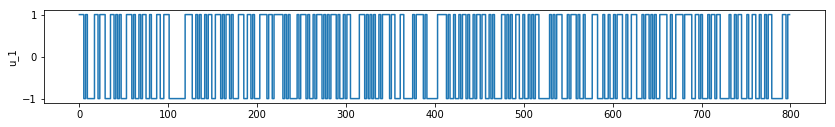

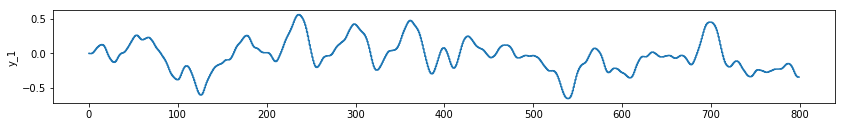

In [3]:
N = len(data["u1"])
plt.figure(figsize=(14,1.7))
plt.step(range(N),data["u1"])
plt.ylabel("u_1")
plt.figure(figsize=(14,1.7))
plt.step(range(N),data["y1"])
plt.ylabel("y_1")
data["u1"].size

## Identify first order model
Consider the model structure 
$$y(k) = \frac{b_0\text{q}+b_1}{\text{q}+a} \text{q}^{-1} u(k),$$
which is a first order model with one zero, one pole and one delay. The true system has $b_0=0.2$, $b_1=0$ and $a=-0.8$.

The ARX model can be written 
$$ y(k+1) = -ay(k) + b_0u(k) + b_1u(k-1) + e(k+1),$$
and so the one-step-ahead predictor becomes
$$ \hat{y}(k+1) = -ay(k) + b_0u(k) + b_1u(k-1) = \begin{bmatrix} -y(k) & u(k) & u(k-1) \end{bmatrix}\begin{bmatrix} a\\b_0\\b_1 \end{bmatrix}. $$

The systems of equations becomes
$$ \underbrace{\begin{bmatrix} -y(2) & u(2) & u(1)\\-y(3) & u(3) & u(2)\\ \vdots & \vdots & \vdots\\ -y(N-1) & u(N-1) & u(N-2) \end{bmatrix}}_{\Phi} \underbrace{\begin{bmatrix} a\\b_0\\b_1\\\end{bmatrix}}_{\theta} =
\begin{bmatrix} y(3)\\y(4)\\\vdots\\y(N) \end{bmatrix},$$
which is solved using least squares.

In [13]:
y = np.ravel(data["y1"])
u = np.ravel(data["u1"])
Phi = np.array([-y[3:N-1], 
                -y[2:N-2], 
                -y[1:N-3], 
                -y[:N-4], 
                u[3:N-1], 
                u[2:N-2], 
                u[1:N-3], 
                u[:N-4]]).T
yy = y[4:]
theta_ls = np.linalg.lstsq(Phi, yy)
theta_ls

(array([ -3.20530434e+00,   3.83874216e+00,  -2.03957413e+00,
          4.07367278e-01,   7.24357743e-05,   6.28322930e-04,
          5.49628069e-04,   7.04225802e-05]),
 array([ 0.00019621]),
 8,
 array([  3.63688932e+01,   3.32523828e+01,   2.44948763e+01,
          1.29223914e+01,   1.24963607e+01,   1.35833767e+00,
          9.91550342e-02,   4.81901311e-03]))

In [29]:
# Five poles four zeros y(k+1) = a1y(k) + a2y(k-1) + a3y(k-2) +a4y(k-3) + a5y(k-4) 
#                                 + b0u(k) + ... + b4u(k-4)
y = np.ravel(data["y1"])
u = np.ravel(data["u1"])
Phi_old = np.array([-y[4:N-1],
                -y[3:N-2], 
                -y[2:N-3], 
                -y[1:N-4], 
                -y[:N-5], 
                u[4:N-1], 
                u[3:N-2], 
                u[2:N-3], 
                u[1:N-4], 
                u[:N-5]]).T
Phi = np.vstack((-y[4:N-1],
                -y[3:N-2], 
                -y[2:N-3], 
                -y[1:N-4], 
                -y[:N-5], 
                u[4:N-1], 
                u[3:N-2], 
                u[2:N-3], 
                u[1:N-4], 
                u[:N-5])).T
yy = y[5:]
theta_ls = np.linalg.lstsq(Phi, yy)
theta_ls
print(np.linalg.solve(np.dot(Phi.T, Phi), np.dot(Phi.T, yy)))
print(theta_ls[0])
print(Phi.shape)

[-3.22987655e+00  3.93586268e+00 -2.18658074e+00  5.08461670e-01
 -2.66559494e-02  7.21326220e-05  6.27381769e-04  5.34425373e-04
  6.90305845e-05  1.09707081e-05]
[-3.22987655e+00  3.93586268e+00 -2.18658074e+00  5.08461670e-01
 -2.66559494e-02  7.21326220e-05  6.27381769e-04  5.34425373e-04
  6.90305846e-05  1.09707081e-05]
(795, 10)


/home/kjartan/.local/lib/python3.5/site-packages/ipykernel_launcher.py:26: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


## Validation
The validation is always done one input-output data that were **not** used in the parameter estimation. It is also recommended to use a k-step-ahead predictor. See section about validation further down.

Order n=5
Data points N=800


Text(0.5,1,'RMSE = 0.093767,  fit = 68.947521 %')

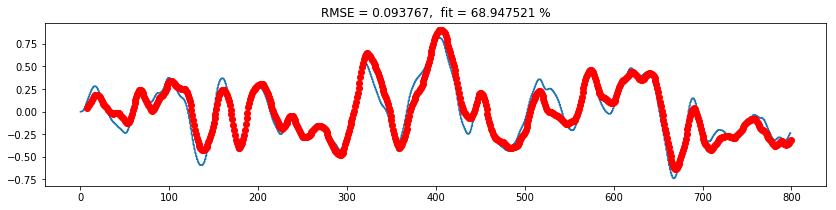

In [14]:
# Import the predict_lti function which will calculate the k-step ahead prediction.
from lti_fcns import predict_lti
yv = np.ravel(data["y1_val"])
uv = np.ravel(data["u1_val"])
k = 8 # The prediction horizon
d = 1 # The input delay of the system
ap = np.ravel(theta_ls[0][:4])
a = np.concatenate(([1.0], ap))
b = np.ravel(theta_ls[0][4:])
(ypred, tpred) = predict_lti(b,a,yv, uv, k, d)
N = len(uv)
plt.figure(figsize=(14,3))
plt.step(range(N), yv)
plt.plot(tpred, ypred, 'ro')

# Calculate the Root Mean Square Error (RMSE) and fit (in %)
err = yv[tpred[0]:] - ypred
RMSE = np.sqrt(1.0/N * np.sum( np.square(yv[tpred[0]:] - ypred)))
fit = 100 * (1 - np.linalg.norm(err)/np.linalg.norm(yv - np.mean(yv)))
plt.title("RMSE = %f,  fit = %f %%" % (RMSE, fit))

Order n=6
Data points N=800


Text(0.5,1,'RMSE = 0.094575,  fit = 68.679699 %')

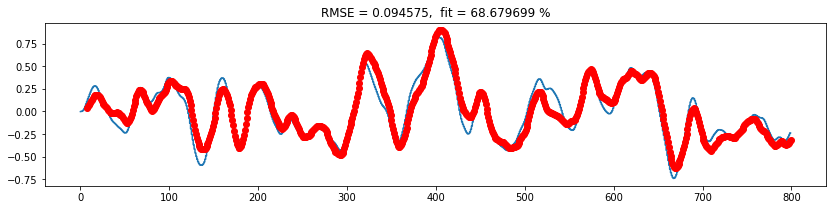

In [30]:
# Import the predict_lti function which will calculate the k-step ahead prediction.
from lti_fcns import predict_lti
yv = np.ravel(data["y1_val"])
uv = np.ravel(data["u1_val"])
k = 8 # The prediction horizon
d = 1 # The input delay of the system
ap = np.ravel(theta_ls[0][:5])
a = np.concatenate(([1.0], ap))
b = np.ravel(theta_ls[0][5:])
(ypred, tpred) = predict_lti(b,a,yv, uv, k, d)
N = len(uv)
plt.figure(figsize=(14,3))
plt.step(range(N), yv)
plt.plot(tpred, ypred, 'ro')

# Calculate the Root Mean Square Error (RMSE) and fit (in %)
err = yv[tpred[0]:] - ypred
RMSE = np.sqrt(1.0/N * np.sum( np.square(yv[tpred[0]:] - ypred)))
fit = 100 * (1 - np.linalg.norm(err)/np.linalg.norm(yv - np.mean(yv)))
plt.title("RMSE = %f,  fit = %f %%" % (RMSE, fit))

In [9]:
np.linalg.cond(Phi)

5519.999832931352

In [20]:
theta_ls = np.linalg.lstsq(Phi, yy)[0]
theta_ls2 = np.linalg.solve(np.dot(Phi.T, Phi), np.dot(Phi.T,yy))
print(a)

[ 1.00000000e+00 -1.57282726e+00  4.72651671e+00 -3.39075305e+00
  8.12911817e-01  9.80671551e-05]


/home/kjartan/.local/lib/python3.5/site-packages/ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.


In [19]:
print(theta_ls)
print(theta_ls2)
print(theta_ls - theta_ls2)




[[-1.57282726e+00]
 [ 4.72651671e+00]
 [-3.39075305e+00]
 [ 8.12911817e-01]
 [ 9.80671551e-05]
 [ 7.33929051e-04]
 [ 1.55372277e-03]
 [ 8.81312997e-04]
 [-7.58562176e-05]]
[[-1.57282726e+00]
 [ 4.72651671e+00]
 [-3.39075305e+00]
 [ 8.12911817e-01]
 [ 9.80671551e-05]
 [ 7.33929051e-04]
 [ 1.55372277e-03]
 [ 8.81312997e-04]
 [-7.58562174e-05]]
[[-4.91138241e-11]
 [ 3.90079080e-10]
 [-4.44801085e-10]
 [ 1.52655000e-10]
 [-2.13299295e-14]
 [ 1.94764994e-14]
 [-8.55179642e-14]
 [-1.11779726e-13]
 [-2.26906249e-13]]


## Estimate the other models on your own

In [28]:
np.vstack((np.arange(3),2*np.arange(3))) 

array([[0, 1, 2],
       [0, 2, 4]])

# About the validation simulation 
In general it is preferred to compare the validation output to the output from a k-step ahead predictor, where k is chosen to correspond to a typical time interval of the data. For control models where we have used the rule-of-thumb of 4-10 sampling periods per rise time, a choice of around $k=10$ is reasonable. A choice of $k=1$ (one-step ahead predictor) gives unreliable validation, since the trivial predictor $\hat{y}(k+1) = y(k)$ can give good predictions if the sampling period is short. Think of the prediction "the weather in one minute from now will be equal to the weather now". Choosing k extremely large corresponds to a pure simulation of the model (the predicted output sequence depends only on the input sequence) and will not work for unstable models. Also, for models with integration a small bias in the input sequence will be accumulated and give poor validation result, even for a good model. 